# Week3 Project 

## 1. Description of the problem and data

### 1.1 Description
In this project, I am going to create a model to correctly identify metastatic cancer in small image patches taken from larger digital pathology scans by leveraging advanced deep learning techniques, such as convolutional neural networks (CNNs), to enhance the accuracy and efficiency of cancer detection, ultimately aiding pathologists in making more precise and timely diagnoses.

### 1.2 Data
- A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
- Kind: TIFF image
- Size: 27,935 bytes (29 KB on disk)
- Dimensions: 96 × 96
- Color space: RGB
- source: [Kaggle Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

### 1.3 Load library

In [2]:
%pip install pathlib2 -q
%pip install numpy==2.0.0 -q
%pip install pandas -q
%pip install matplotlib -q
%pip install tensorflow -q
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import pathlib2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Exploratory Data Analysis (EDA)

### 2.1 Load data

In [5]:
# Paths to the data directories
train_path = './data/train/'
test_path = './data/test/'
train_labels_path = './data/train_labels.csv'

# path to Path obj
train_dir = pathlib2.Path(train_path)
test_dir = pathlib2.Path(test_path)

# list image in train and test dir
train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

# Load the train_labels
df_train_labels = pd.read_csv(train_labels_path)

### 2.2 Check missing value

In [4]:
df_train_labels.isna().sum()

id       0
label    0
dtype: int64

### 2.3 Check data distribution

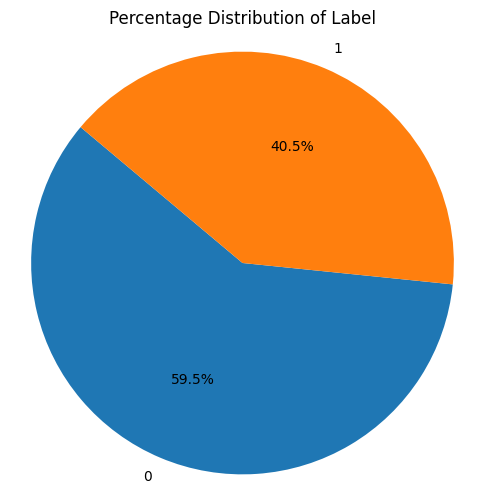

In [6]:
def draw_pie(df):

    label_count = df['label'].value_counts()
    labels = label_count.index
    sizes = label_count.values

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Percentage Distribution of Label')
    plt.axis('equal') 
    plt.show()

draw_pie(df_train_labels)

### 2.4 Check data sample

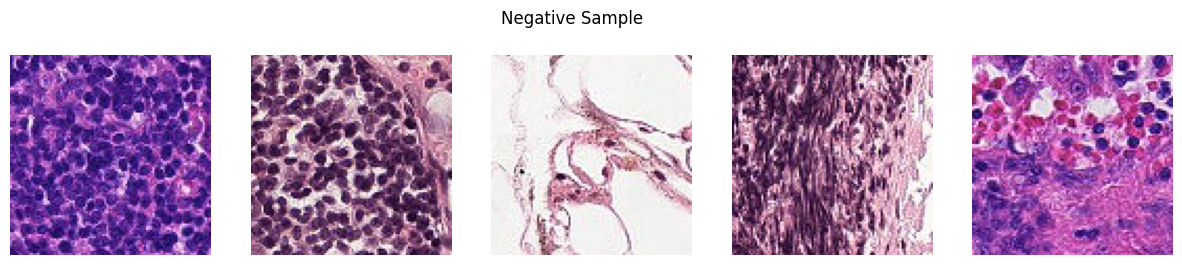

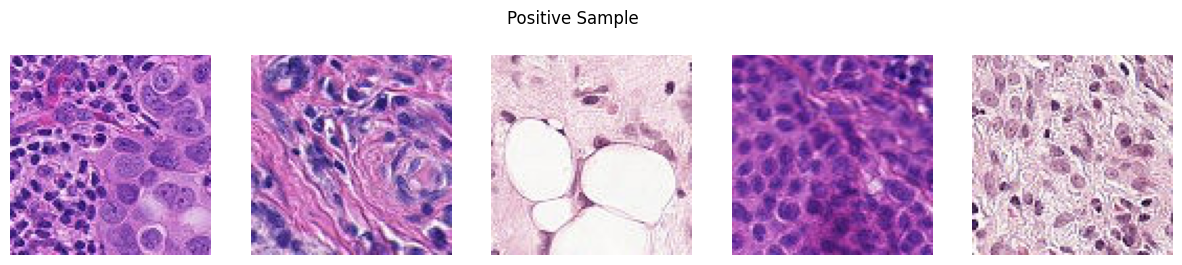

In [38]:
def data_sample(label):
    selected = df_train_labels[df_train_labels['label'] == label] 
    samples = selected.sample(5)

    plt.figure(figsize=(15, 3))

    for i, img_id in enumerate(samples['id']):
        img_path = os.path.join(train_dir, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    
    title = 'Negative' if label == 0 else 'Positive'

    plt.suptitle(f'{title} Sample')
    plt.show()

data_sample(0)
data_sample(1)

## 3. Model Architecture

### 3.1 Basic Model

#### Description

Include:

- `Input`: The data description mentioned that the center 32 $\times$ 32 region is the critical region to decide the label, however the outer area also provide useful info. Therefore, I choose to retain the full image(96 $\times$ 96) as input.
- `Conv2d`: Used to extract loacal features such as edges and textures.
- `MaxPooling2D`: Reducing spatial dimensions of feature maps, decreasing computational load.
- `Dense`: Used to classify. 


In [ ]:
config0 = [
    # Input Layer
    Input(shape=(96, 96, 3)),
    
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),

    # Output Layer
    Dense(1, activation='sigmoid')
]

model0 = Sequential(config0)
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model0.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_114               │ (None, 47, 47, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 70688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │     9,048,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,049,217 (34.52 MB)

 Trainable params: 9,049,217 (34.52 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Advanced Model

#### Description
Add: 
- Another `Conv2d`
- `Batchnormalization`: Stablizing and accerlating training
- `Dropout`: Prevent overfitting

In [196]:
config1 = [
    # Input Layer
    Input(shape=(96, 96, 3)),
    
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(1, activation='sigmoid')
]

model1 = Sequential(config1)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_120 (Conv2D)             │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_120               │ (None, 47, 47, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 47, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_121 (Conv2D)             │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_121               │ (None, 22, 22, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_93          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,961 (15.20 MB)

 Trainable params: 3,984,769 (15.20 MB)

 Non-trainable params: 192 (768.00 B)

## 4. Results and Analysis

### 4.0 Visualize Result function

In [209]:
def show_result(history):
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Result')
    plt.legend()
    plt.show()

### 4.1 Data preparing

In [208]:
# add filename column
df_train_labels['filename'] = df_train_labels['id'] + '.tif'
df_train_labels['label'] = df_train_labels['label'].astype(str)

batch_size = 32
target_size = (96, 96)
validation_split = 0.2

# train and val datagen
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=validation_split
)

# train and val generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train_labels,
    directory=train_dir,
    x_clo='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training',
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_train_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation',
    seed=42
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### 4.2 Training model

#### 4.2.1 Model0

In [198]:
history0 = model0.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7763 - loss: 0.4798

/Users/chia-hongchang/Documents/CU Boulder/Machine Learning/Deep Learning/Module3/Project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 429s 78ms/step - accuracy: 0.7763 - loss: 0.4798 - val_accuracy: 0.7634 - val_loss: 0.5125
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 461s 84ms/step - accuracy: 0.8033 - loss: 0.4371 - val_accuracy: 0.7983 - val_loss: 0.4444
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 473s 86ms/step - accuracy: 0.8087 - loss: 0.4254 - val_accuracy: 0.7932 - val_loss: 0.4666
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 474s 86ms/step - accuracy: 0.8166 - loss: 0.4132 - val_accuracy: 0.8123 - val_loss: 0.4414
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 475s 86ms/step - accuracy: 0.8207 - loss: 0.4065 - val_accuracy: 0.7610 - val_loss: 0.5525


#### 4.2.2 Model1

In [199]:
history1 = model1.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 650s 118ms/step - accuracy: 0.7798 - loss: 0.9739 - val_accuracy: 0.7914 - val_loss: 0.4945
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 647s 118ms/step - accuracy: 0.8279 - loss: 0.4042 - val_accuracy: 0.6489 - val_loss: 4.2591
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 657s 119ms/step - accuracy: 0.8366 - loss: 0.3824 - val_accuracy: 0.7260 - val_loss: 1.0300
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 665s 121ms/step - accuracy: 0.8474 - loss: 0.3634 - val_accuracy: 0.7872 - val_loss: 0.5657
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 673s 122ms/step - accuracy: 0.8541 - loss: 0.3496 - val_accuracy: 0.8542 - val_loss: 0.4733


#### Result
- Model1 has one more convolution layer and use batchnormalization layer, so it's performance is better than model0.

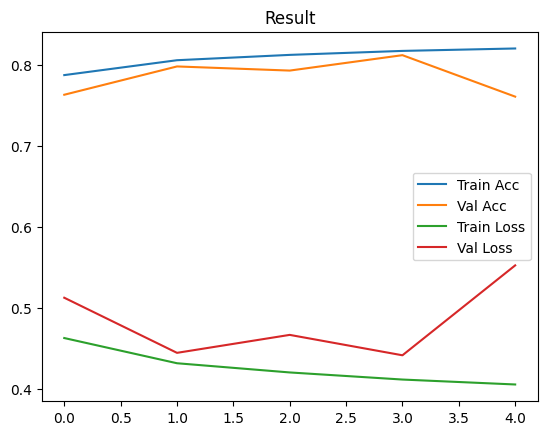

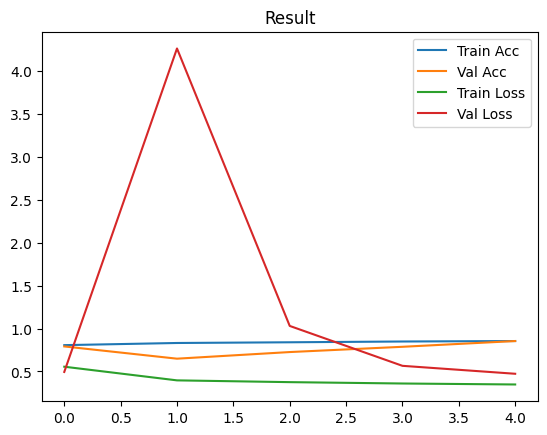

In [215]:
show_result(history0)
show_result(history1)

### 4.3 Tunning model

#### 4.3.1 Learning rate

1. Learning rate = 0.0001

In [200]:
learning_rate = 0.0001
opt = Adam(learning_rate = learning_rate)
model3 = Sequential(config0)
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


history3 = model3.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 467s 85ms/step - accuracy: 0.8329 - loss: 0.3812 - val_accuracy: 0.7881 - val_loss: 0.4963
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 483s 88ms/step - accuracy: 0.8367 - loss: 0.3726 - val_accuracy: 0.7907 - val_loss: 0.4856
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 485s 88ms/step - accuracy: 0.8374 - loss: 0.3725 - val_accuracy: 0.7914 - val_loss: 0.4938
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 471s 86ms/step - accuracy: 0.8382 - loss: 0.3712 - val_accuracy: 0.7935 - val_loss: 0.4820
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 479s 87ms/step - accuracy: 0.8364 - loss: 0.3728 - val_accuracy: 0.7981 - val_loss: 0.4744


2. Learning rate = 0.01

In [201]:
learning_rate = 0.01
opt = Adam(learning_rate = learning_rate)
model4 = Sequential(config0)
model4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


history4 = model4.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 478s 87ms/step - accuracy: 0.6398 - loss: 0.6555 - val_accuracy: 0.5961 - val_loss: 0.6747
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 466s 85ms/step - accuracy: 0.5947 - loss: 0.6754 - val_accuracy: 0.5961 - val_loss: 0.6750
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 481s 87ms/step - accuracy: 0.5951 - loss: 0.6752 - val_accuracy: 0.5961 - val_loss: 0.6747
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 483s 88ms/step - accuracy: 0.5951 - loss: 0.6751 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 474s 86ms/step - accuracy: 0.5930 - loss: 0.6760 - val_accuracy: 0.5961 - val_loss: 0.6762


3. Result
- Higher learning rate lead to lower accuracy, while lower leaning rate increase the accuracy.

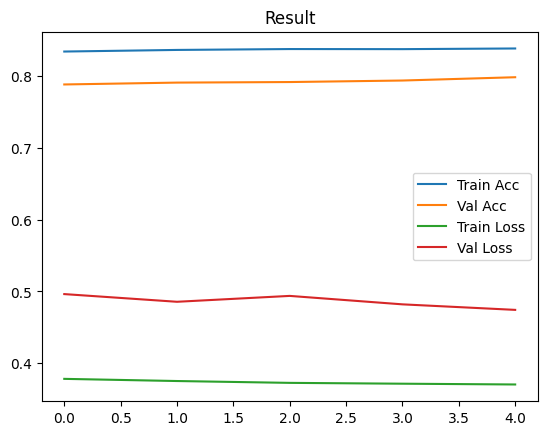

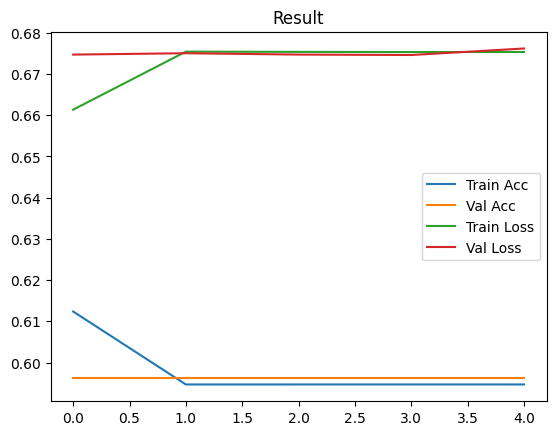

In [213]:
show_result(history3)
show_result(history4)

#### 4.3.2 Epoch

1. Epoch = 3

In [204]:
model5 = Sequential(config0)
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history5 = model5.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 468s 84ms/step - accuracy: 0.5938 - loss: 0.6755 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 469s 85ms/step - accuracy: 0.5975 - loss: 0.6740 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 488s 89ms/step - accuracy: 0.5958 - loss: 0.6747 - val_accuracy: 0.5961 - val_loss: 0.6746


2. Epoch = 8

In [205]:
model6 = Sequential(config0)
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history6 = model6.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator
)

Epoch 1/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 482s 87ms/step - accuracy: 0.5956 - loss: 0.6748 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 2/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 478s 87ms/step - accuracy: 0.5959 - loss: 0.6746 - val_accuracy: 0.5961 - val_loss: 0.6747
Epoch 3/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 478s 87ms/step - accuracy: 0.5929 - loss: 0.6758 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 4/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 470s 85ms/step - accuracy: 0.5931 - loss: 0.6757 - val_accuracy: 0.5961 - val_loss: 0.6745
Epoch 5/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 487s 89ms/step - accuracy: 0.5946 - loss: 0.6752 - val_accuracy: 0.5961 - val_loss: 0.6745
Epoch 6/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 472s 86ms/step - accuracy: 0.5927 - loss: 0.6759 - val_accuracy: 0.5961 - val_loss: 0.6745
Epoch 7/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 467s 85ms/step - accuracy: 0.5943 - loss: 0.6753 - val_accuracy: 0.5961 - val_loss: 0.6746
Epoch 8/8
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 469s 85ms/step - accuracy: 0.5933 -

3. Result
- More epochs or less epochs doesn't have to much improve on the model, but get a lower accuracy.

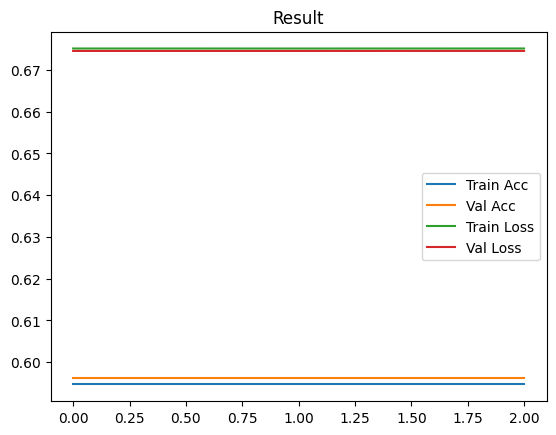

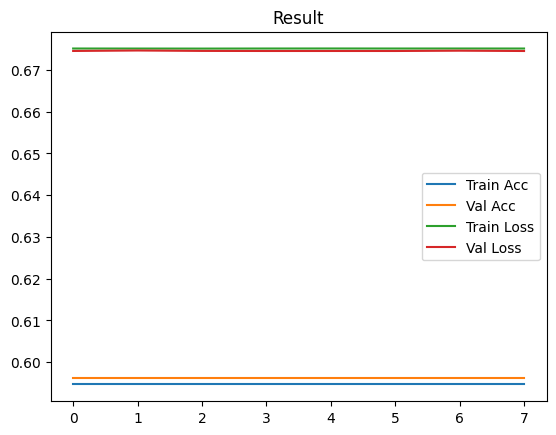

In [214]:
show_result(history5)
show_result(history6)

## 5. Conclusion

- Use more convolution layer and batchnormalization can improve the models performance.
- Use lower learning rate can get a higher accuracy.
- Use more epochs or less epoch cannot improve the models' performance but get a lower accuracy.

#### Submission

- Prepare test data 

In [ ]:
test_filenames = os.listdir(test_dir)
df_test = pd.DataFrame({'filename': test_filenames})
df_submission = pd.DataFrame()

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


- Predict

In [224]:
predictions = model1.predict(test_generator, verbose=1)

   1/1796 ━━━━━━━━━━━━━━━━━━━━ 1:50 62ms/step

/Users/chia-hongchang/Documents/CU Boulder/Machine Learning/Deep Learning/Module3/Project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step


- Prepare submission data

In [239]:
df_submission['id'] = df_test['filename'].str.replace('.tif', '', regex=False)
df_submission['label'] = list(0 if x < 0.5 else 1 for x in predictions)

df_submission.to_csv('submission.csv', index=False)
df_submission.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,1
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,0
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0
